# **Image Classification using Keras and TensorFlow**


![alt text](https://blogs.biomedcentral.com/on-medicine/wp-content/uploads/sites/6/2019/09/iStock-1131794876.t5d482e40.m800.xtDADj9SvTVFjzuNeGuNUUGY4tm5d6UGU5tkKM0s3iPk-620x342.jpg)

##**Importing the required libraries**

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
import tensorflow.keras.backend as K

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

import os
import random
from shutil import copy

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

##**Mount drive to extract dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Extract dataset**

In [ ]:
!unzip /content/drive/MyDrive/dataset_mancare/dataset.zip -d /content

Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
  inflating: /content/dataset/images/fish_and_chips/1018454.jpg  
  inflating: /content/dataset/images/fish_and_chips/1030796.jpg  
  inflating: /content/dataset/images/fish_and_chips/1035054.jpg  
  inflating: /content/dataset/images/fish_and_chips/1035379.jpg  
  inflating: /content/dataset/images/fish_and_chips/1050942.jpg  
  inflating: /content/dataset/images/fish_and_chips/1054214.jpg  
  inflating: /content/dataset/images/fish_and_chips/1063281.jpg  
  inflating: /content/dataset/images/fish_and_chips/1063525.jpg  
  inflating: /content/dataset/images/fish_and_chips/106755.jpg  
  inflating: /content/dataset/images/fish_and_chips/1072334.jpg  
  inflating: /content/dataset/images/fish_and_chips/1082654.jpg  
  inflating: /content/dataset/images/fish_and_chips/1085414.jpg  
  inflating: /content/dataset/images/fish_and_chips/1086970.jpg  
  inflating: /content/dataset/images/fish_and_chips/1089396.jpg  
  infla

###**Checking the structure of dataset folder**

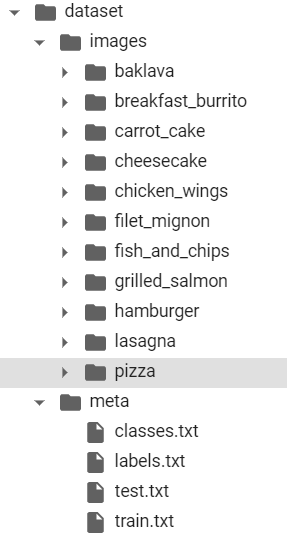

The dataset folder has 2 subfolders:
* 'images' -> Contains 11 folders representing the classes, each with 1000 images
* 'meta' -> Contains metadata of the dataset:
    - 'classes.txt' -> The list of classes
    - 'labels.txt' -> The names of the classes
    - 'train.txt' -> A list of train images names
    - 'test.txt' -> A list of train images names

'train.txt' and 'test.txt' folders contains data that has format:

      class_that_belongs_to / image_name

###**Checking the metadata files**

In [ ]:
!head dataset/meta/train.txt

baklava/1006121
baklava/1014880
baklava/1021344
baklava/1024334
baklava/1031470
baklava/1034361
baklava/1042057
baklava/1044163
baklava/1045575
baklava/1049559


In [ ]:
!head dataset/meta/test.txt

baklava/1028777
baklava/1029051
baklava/104446
baklava/1062541
baklava/1067270
baklava/1075871
baklava/107830
baklava/1110172
baklava/1118803
baklava/1138123


In [ ]:
%cat dataset/meta/classes.txt

baklava
breakfast_burrito
carrot_cake
cheesecake
chicken_wings
filet_mignon
fish_and_chips
grilled_salmon
hamburger
lasagna
pizza

In [ ]:
%cat dataset/meta/labels.txt

Baklava
Breakfast burrito
Carrot cake
Cheesecake
Chicken wings
Filet mignon
Fish and chips
Grilled salmon
Hamburger
Lasagna
Pizza

## **Visualize a random image from each of the 11 classes**

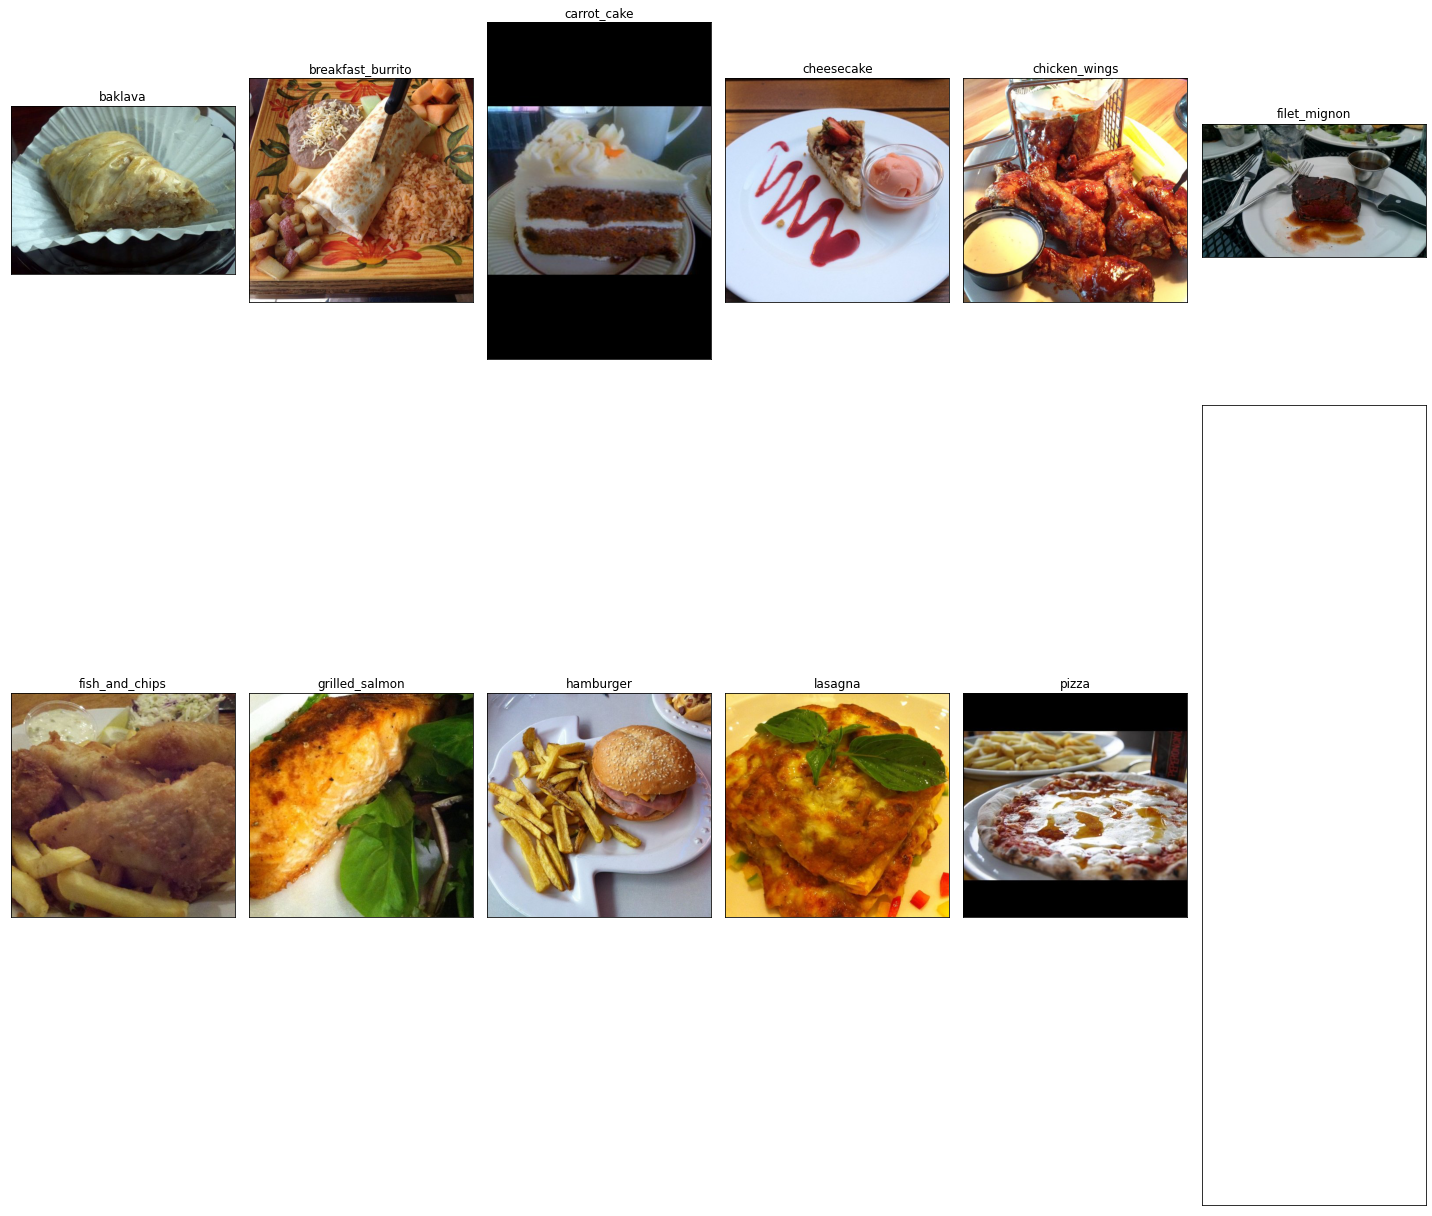

In [ ]:
rows = 2
columns = 6
fig, ax = plt.subplots(rows, columns, figsize = (20, 20))

data_dir = "dataset/images/"
classes_sorted = sorted(os.listdir(data_dir))

for i in range(rows):
  for j in range(columns):
    try:
      class_name = classes_sorted[columns*i + j]
    except:
      break

    images_of_selected_class = os.listdir(os.path.join(data_dir, class_name))
    selected_image = np.random.choice(images_of_selected_class)

    img = plt.imread(os.path.join(data_dir, class_name, selected_image))

    ax[i][j].imshow(img)
    ax[i][j].set_title(class_name)

plt.setp(ax, xticks = [], yticks = [])
plt.tight_layout()


## **Split the image data into train and test using train.txt and test.txt**

In [ ]:
def move_data(images_list, source, destination):
  classes = defaultdict(list)
  
  print('Getting files paths...')
  with open(images_list, 'r') as txt:
    images_paths = [read.strip() for read in txt.readlines()]
    for image_path in images_paths:
      sample = image_path.split('/')
      classes[sample[0]].append(sample[1] + '.jpg')
  
  for classs in classes.keys():
    print('\nCreating subfolder for class ' + classs)

    if not os.path.exists(os.path.join(destination, classs)):
      os.makedirs(os.path.join(destination, classs))

    print('Copying images to subfolder ' + classs)

    for image in classes[classs]:
      copy(os.path.join(source, classs, image), os.path.join(destination, classs, image))
    
  print('\nDone!!!')

In [ ]:
move_data('/content/dataset/meta/train.txt', '/content/dataset/images', '/content/tmp/train')

Getting files paths...

Creating subfolder for class baklava
Copying images to subfolder baklava

Creating subfolder for class breakfast_burrito
Copying images to subfolder breakfast_burrito

Creating subfolder for class carrot_cake
Copying images to subfolder carrot_cake

Creating subfolder for class cheesecake
Copying images to subfolder cheesecake

Creating subfolder for class chicken_wings
Copying images to subfolder chicken_wings

Creating subfolder for class filet_mignon
Copying images to subfolder filet_mignon

Creating subfolder for class fish_and_chips
Copying images to subfolder fish_and_chips

Creating subfolder for class grilled_salmon
Copying images to subfolder grilled_salmon

Creating subfolder for class hamburger
Copying images to subfolder hamburger

Creating subfolder for class lasagna
Copying images to subfolder lasagna

Creating subfolder for class pizza
Copying images to subfolder pizza

Done!!!


In [ ]:
move_data('/content/dataset/meta/test.txt', '/content/dataset/images', '/content/tmp/test')

Getting files paths...

Creating subfolder for class baklava
Copying images to subfolder baklava

Creating subfolder for class breakfast_burrito
Copying images to subfolder breakfast_burrito

Creating subfolder for class carrot_cake
Copying images to subfolder carrot_cake

Creating subfolder for class cheesecake
Copying images to subfolder cheesecake

Creating subfolder for class chicken_wings
Copying images to subfolder chicken_wings

Creating subfolder for class filet_mignon
Copying images to subfolder filet_mignon

Creating subfolder for class fish_and_chips
Copying images to subfolder fish_and_chips

Creating subfolder for class grilled_salmon
Copying images to subfolder grilled_salmon

Creating subfolder for class hamburger
Copying images to subfolder hamburger

Creating subfolder for class lasagna
Copying images to subfolder lasagna

Creating subfolder for class pizza
Copying images to subfolder pizza

Done!!!


###**Now, the tmp folder should look like this**

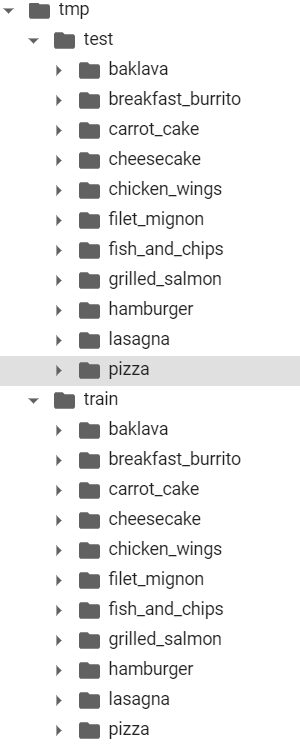

###**Check files dimensions**

In [ ]:
print("Distribution: 75% train, 25% test\n")

print("Number of train images: ")
!find /content/tmp/train/ -type d -or -type f -printf '.' | wc -c

print("Number of test images: ")
!find /content/tmp/test/ -type d -or -type f -printf '.' | wc -c

Distribution: 75% train, 25% test

Number of train images: 
8250
Number of test images: 
2750


##**Plot the distribution for both, train and test**

In [ ]:
def file_ditribution(path):
  distribution = {}

  for filename in os.listdir(path):
    for base, dirs, files in os.walk(os.path.join(path, filename)):
      distribution[filename] = len(files)

  return list(distribution.keys()), list(distribution.values())

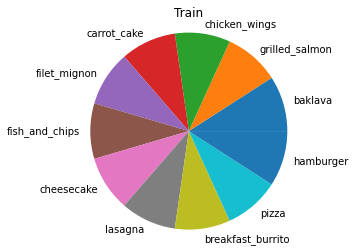

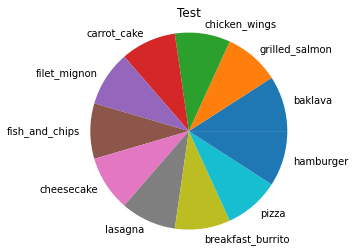

In [ ]:
train_labels, train_values = file_ditribution('/content/tmp/train')
test_labels, test_values = file_ditribution('/content/tmp/test')

plt.pie(train_values, labels=train_labels)
plt.axis('equal')
plt.title('Train')
plt.show()

plt.pie(test_values, labels=test_labels)
plt.axis('equal')
plt.title('Test')
plt.show()

## **Building the model and train**

* Keras and other Deep Learning libraries provide pretrained models  
* These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet  
* Using these pretrained models, we can use the already learned weights and add few layers on top to finetune the model to our new data  
* This helps in faster convergance and saves time and computation when compared to models trained from scratch

In [ ]:
batch_size = 32
epochs = 25

lr = 0.0001
momentum = 0.9

dropout_rate = 0.3
l1_rate = None
l2_rate = 0.005

regularizer = regularizers.l2(l2_rate) # Alternatives: l1 / l1_l2 / l2
optimizer = SGD(lr = lr, momentum = momentum) # Alternatives: Adam / RMSprop

no_classes = 11
image_width, image_height = 299, 299

train_directory = '/content/tmp/train/'
test_directory = '/content/tmp/test/'

no_train_samples = 8250
no_test_samples = 2750
steps_per_epoch = no_train_samples // batch_size
test_steps = no_test_samples // batch_size

train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'categorical')

inception = InceptionV3(weights = 'imagenet', include_top = False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(dropout_rate)(x)

predictions = Dense(no_classes, kernel_regularizer = regularizer, activation = 'softmax')(x)

model = Model(inputs = inception.input, outputs = predictions)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath = '/content/best_model.hdf5', verbose = 1, save_best_only = True)
logger = CSVLogger('/content/history.log')

history = model.fit(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_generator,
                    validation_steps = test_steps,
                    epochs = epochs,
                    verbose = 1,
                    callbacks = [logger, checkpointer]
                    )

Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.
87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/25
257/257 [==============================] - 266s 870ms/step - loss: 2.5167 - accuracy: 0.1493 - val_loss: 2.0840 - val_accuracy: 0.4581

Epoch 00001: val_loss improved from inf to 2.08395, saving model to /content/best_model.hdf5
Epoch 2/25
257/257 [==============================] - 220s 854ms/step - loss: 2.0789 - accuracy: 0.3711 - val_loss: 1.6209 - val_accuracy: 0.6386

Epoch 00002: val_loss improved from 2.08395 to 1.62087, saving model to /content/best_model.hdf5
Epoch 3/25
257/257 [==============================] - 220s 855ms/step - loss: 1.6766 - accuracy: 0.5278 - val_loss: 1.2172 - val_accuracy: 0.7268

Epoch 00003: val_loss improved from 1.62087 to 1.21722, saving model to /content/best_model.hdf5
Epoch 4/25
257/257 [==============================] - 221s 859ms/step - loss: 1.3756 - accuracy: 0.6204 - val_loss: 0.956

###**Continue training with a saved model**

In [ ]:
model = load_model('/content/best_model.hdf5')
history = model.fit(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_generator,
                    validation_steps = test_steps,
                    epochs = epochs,
                    verbose = 1,
                    callbacks = [logger, checkpointer]
                    )

NameError: ignored

##**Plot the evolution of the loss and accuracy**

In [ ]:
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'best')
    plt.show()

def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'best')
    plt.show()

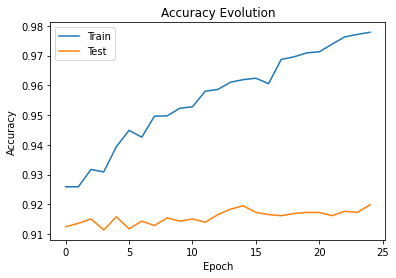

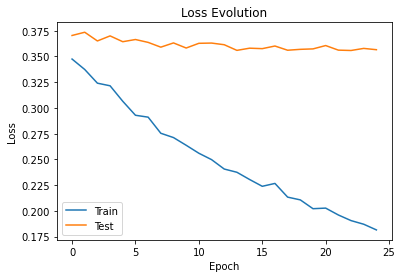

In [ ]:
plot_accuracy(history, 'Accuracy Evolution')
plot_loss(history, 'Loss Evolution')

### **Predicting classes for new images using the best trained model**

In [ ]:
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('/content/drive/MyDrive/model_antrenat/best_model.hdf5',compile = False)

* **Setting compile=False and clearing the session leads to faster loading of the saved model**


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    
    prediction = classes_sorted[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(prediction)
        plt.show()

In [ ]:
# Upload images
from google.colab import files
files.upload()

Saving baklava.jpg to baklava.jpg
Saving breakfast_burito.jpg to breakfast_burito.jpg
Saving carrot_cake.jpg to carrot_cake.jpg
Saving cheesecake.jpg to cheesecake.jpg
Saving chicken_wings.jpg to chicken_wings.jpg
Saving fillet_mignon.jpg to fillet_mignon.jpg
Saving fish_and_chips.jpg to fish_and_chips.jpg
Saving grilled_salmon.jpg to grilled_salmon.jpg
Saving hamburger.jpg to hamburger.jpg
Saving lasagna.jpg to lasagna.jpg
Saving pizza.jpg to pizza.jpg


{'baklava.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\n\x07\x08\x16\x16\x15\x18\x16\x16\x16\x19\x19\x18\x19\x1a\x1a\x18\x1a\x1c\x1c\x19\x1a\x1c\x1a\x1e\x1f\x1a\x1a\x1a\x1a\x1c\x18\x1a\x1a\x1c!.%\x1c\x1e+\x1f\x18\x18&8&+/1555\x1a$;@;4?.451\x01\x0c\x0c\x0c\x10\x0f\x10\x1f\x12\x12\x1f4,%,544:??44464444444446444444444444441444444444444444\xff\xc0\x00\x11\x08\x00\xe1\x00\xe1\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x02\x03\x06\x00\x01\x07\xff\xc4\x00=\x10\x00\x02\x01\x02\x04\x04\x03\x06\x04\x04\x05\x04\x03\x00\x00\x00\x01\x02\x11\x00\x03\x04\x12!1\x05AQa\x06"q\x132\x81\x91\xa1\xb1\x14B\xc1\xf0\x15R\xd1\xf1#b\x82\x92\xe1\x07r\xb2\xc2\x163\xa2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x00\x05\x06\xff\xc4\x00-\x11\x00\x03\x00\x02\x01\x03\x04\x01\x03\x03\x05\x01\x00\x00\x00\x00\x00\x01\x02\x03\x11!\

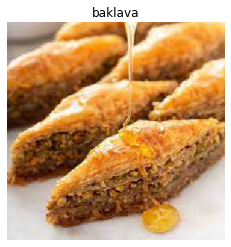

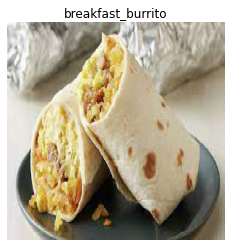

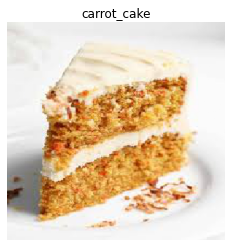

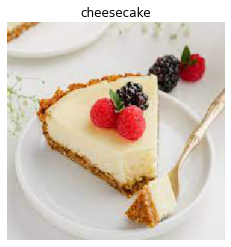

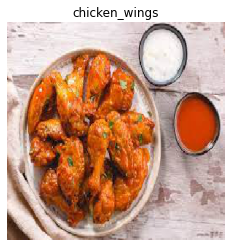

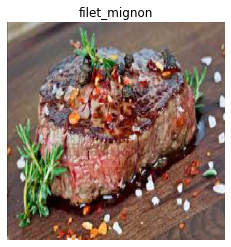

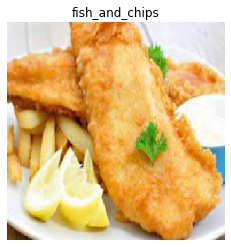

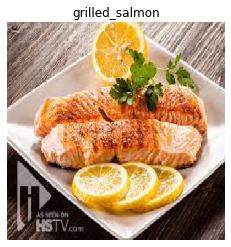

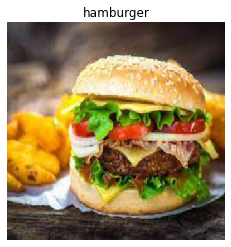

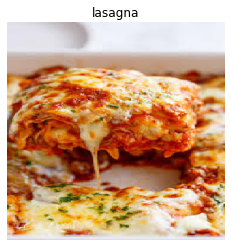

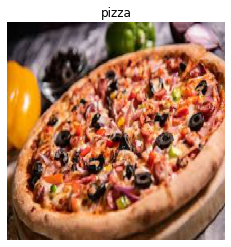

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('baklava.jpg')
images.append('breakfast_burito.jpg')
images.append('carrot_cake.jpg')
images.append('cheesecake.jpg')
images.append('chicken_wings.jpg')
images.append('fillet_mignon.jpg')
images.append('fish_and_chips.jpg')
images.append('grilled_salmon.jpg')
images.append('hamburger.jpg')
images.append('lasagna.jpg')
images.append('pizza.jpg')
predict_class(model_best, images, True)

* **Yes!!! The model got them all right!!**